# Import Libraries

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from synthetic import simulate_var
from models.ckan import cKAN, train_model_ckan, rearrange_data, create_dataset, plot_GC, plot_scores
from models.cmlp import cMLP, train_model_ista

# Setup hyper-parameters

In [2]:
# Setup for the synthetic data
lag = 2  # number of lags
T = 250  # number of time points
num_series = 20  # number of time series
num_factors = 2  # number of factors
sparsity = num_factors / num_series  # sparsity of the Causality matrix
sd = 0.01

# Setup for the training 
epochs = 500 
lr = 1e-3 
dim_input = num_series * lag
dim_output = 1
lamb = 3e-6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Simulate Data

X_np shape:  (250, 20)
beta shape:  (20, 40)
GC shape:  (20, 20)
X shape:  torch.Size([1, 250, 20])


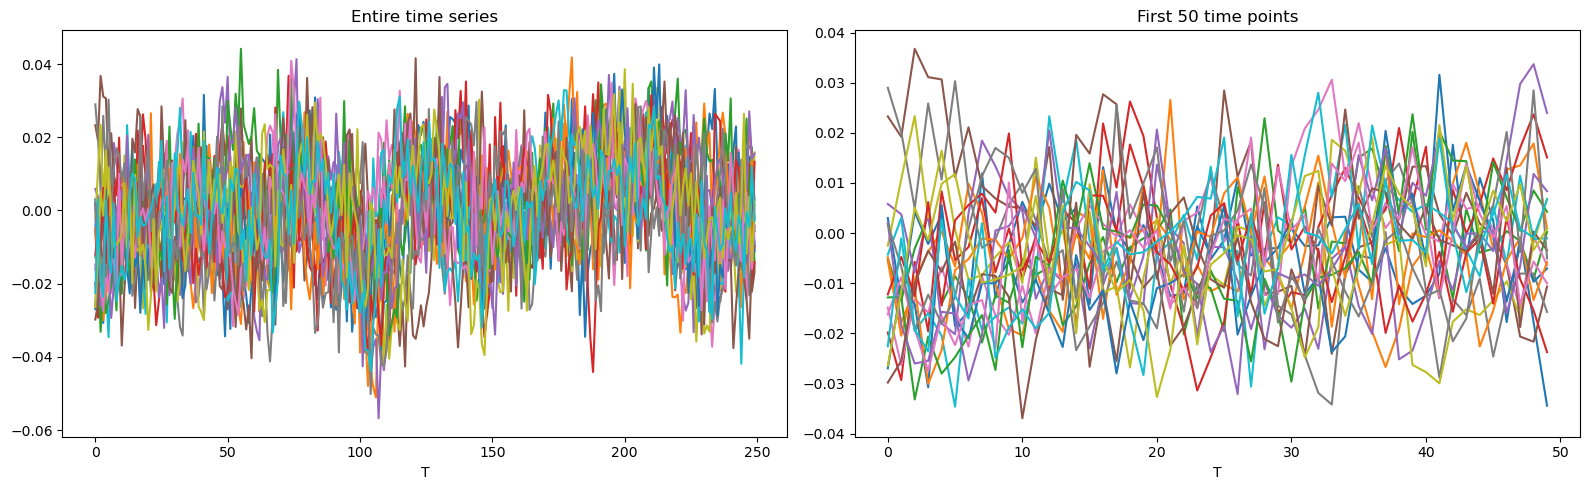

In [3]:
# Simulate data
X_np, beta, GC = simulate_var(p=num_series, T=T, lag=lag, sparsity=sparsity, sd=sd)
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32)  # add one new dimension for X

print("X_np shape: ", X_np.shape)
print('beta shape: ', beta.shape)
print('GC shape: ', GC.shape)
print('X shape: ', X.shape)

# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(X_np)
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')
axarr[1].plot(X_np[:50])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points')
plt.tight_layout()
plt.show()

# Create cKAN and cMLP

In [4]:
widths = [6]

# Build cKAN models
cKANs = [
    cKAN(num_series, lag, hidden=[dim_input, width, dim_output], grid=3, k=3).to(device)
    for width in widths
]

# Build cMLP models
cMLPs = [
    cMLP(num_series, lag, hidden=[width]).to(device) 
    for width in widths
]

# Train cKAN

In [6]:
# Train the cKAN models

results_ckan = []  # store the training losses of the cKAN models
for cKAN in cKANs:
    print('Training cKAN with hidden width: ', cKAN.hidden[1])
    loss_kan = train_model_ckan(cKAN, X, max_iter=epochs, lr=lr, lamb=lamb)
    results_ckan.append(loss_kan)

Training cKAN with width:  6


100%|██████████| 500/500 [00:06<00:00, 76.62it/s, loss=7.73e-5, reg_loss=0.601] 


cKAN hidden width =  6
Accuracy = 100.00%


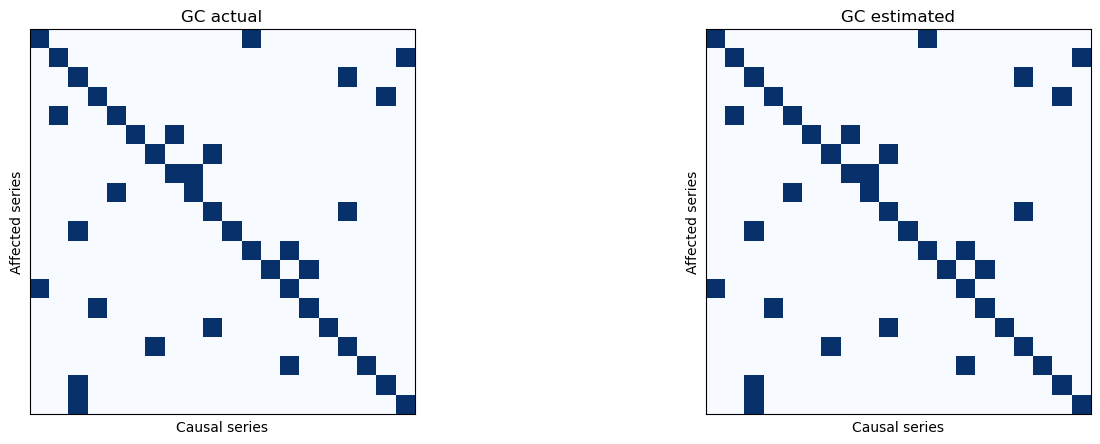

In [15]:
# Fetch GC with topk method
ckan_GCs = [cKAN.GC(X, threshold=None, topk=2) for cKAN in cKANs]

# Plot the GC results
for i, cKAN_GC in enumerate(ckan_GCs):
    # print accuracy using percentage of correctly identified edges
    print('cKAN hidden width = ', cKANs[i].hidden[1])
    print('Accuracy = %.2f%%' % (np.sum(cKAN_GC == GC) / GC.size * 100))
    plot_GC(GC, cKAN_GC)

# Train cMLP

In [19]:
results_cmlp = []  # store the training losses of the cMLP models
for cMLP in cMLPs:
    print('Training cMLP with hidden width: ', widths[0])
    loss_cmlp = train_model_ista(cMLP, X, max_iter=epochs, lr=lr, lam=lamb)
    results_cmlp.append(loss_cmlp)

Training cMLP with hidden width:  6
----------Iter = 100----------
Loss = 0.025360
----------Iter = 200----------
Loss = 0.015610
----------Iter = 300----------
Loss = 0.009672
----------Iter = 400----------
Loss = 0.006049
----------Iter = 500----------
Loss = 0.003832


cMLP hidden width =  6
Accuracy = 82.50%


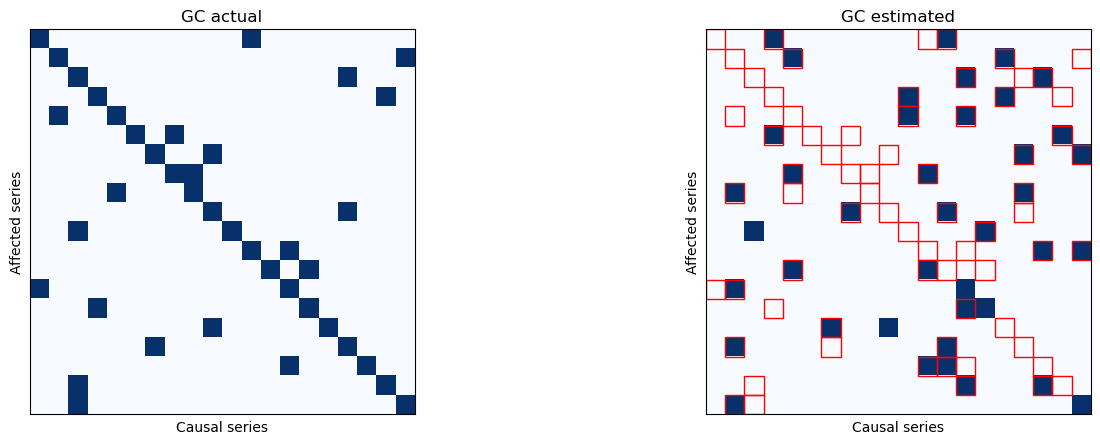

In [22]:
# Fetch GC with topk method
cmlp_GCs = [cMLP.GC(topk=2).cpu().data.numpy() for cMLP in cMLPs]

# Plot the GC results
for i, cMLP_GC in enumerate(cmlp_GCs):
    # print accuracy using percentage of correctly identified edges
    print('cMLP hidden width = ', widths[i])
    print('Accuracy = %.2f%%' % (np.sum(cMLP_GC == GC) / GC.size * 100))
    plot_GC(GC, cMLP_GC)